In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

import csv

import requests

In [69]:
def read_data(data):
    pos = []
    vel = []

    run = False
    data = data.split("\n")
    for row in data:
        if row == "$$SOE": 
            run=True
            continue
        if row == "$$EOE": run=False
        if run:
            pos.append(row.split(",")[2:5])
            vel.append(row.split(",")[5:8])

    return np.asarray(pos).astype(float), np.asarray(vel).astype(float)

# API call

In [70]:
# https://ssd-api.jpl.nasa.gov/doc/horizons.html

url = "https://ssd.jpl.nasa.gov/api/horizons.api"
format = "format=text"
command = "COMMAND=" # target body
targets = ["10", "199", "299", "399", "301", "499", "599", "699", "799", "899"]  # sun, mercury, venus, earth, moon, mars, jupiter, saturn, uranus, neptun
target_names = ["sun", "mercury", "venus", "earth", "moon", "mars", "jupiter", "saturn", "uranus", "neptun"]
obj_data = "OBJ_DATA='NO'"
ephemeris = "MAKE_EPHEM='YES'"
eph_type = "EPHEM_TYPE='VECTORS'"
vec_table = "VEC_TABLE='2'"
center = "CENTER='500@0'"
start = "START_TIME='1800-01-01'"
stop = "STOP_TIME='2023-01-01'"
step = "STEP_SIZE='1 year'"
cal_type = "CAL_TYPE=GREGORIAN"
vector_labels = "VEC_LABELS=NO"
csv_format = "CSV_FORMAT=YES"
units = "OUT_UNITS='AU-D'"
#quantities = "QUANTITIES='1,9,20,23,24,29'"

In [71]:
data = []
for target in targets:
    path = url+"?"+format+"&"+command+target+"&"+obj_data+"&"+ephemeris+"&"+eph_type+"&"+vec_table+"&"+center+"&"+start+"&"+stop+"&"+step+"&"+cal_type+"&"+vector_labels+"&"+csv_format+"&"+units
    q, p = read_data(requests.get(path).text)
    data.append([[q], [p]])
    
data = np.asarray(data).reshape((len(targets),2,len(data[0][0][0]),3))

In [72]:
print(data.shape)

(10, 2, 224, 3)


## Data shape

9 x target body <br>
2 x vectors - q & p <br>
n x data points <br>
3 x coordinates - x, y, z

# Phase spaces for all bodies in the system

Text(0.5, 0.98, 'Phase spaces')

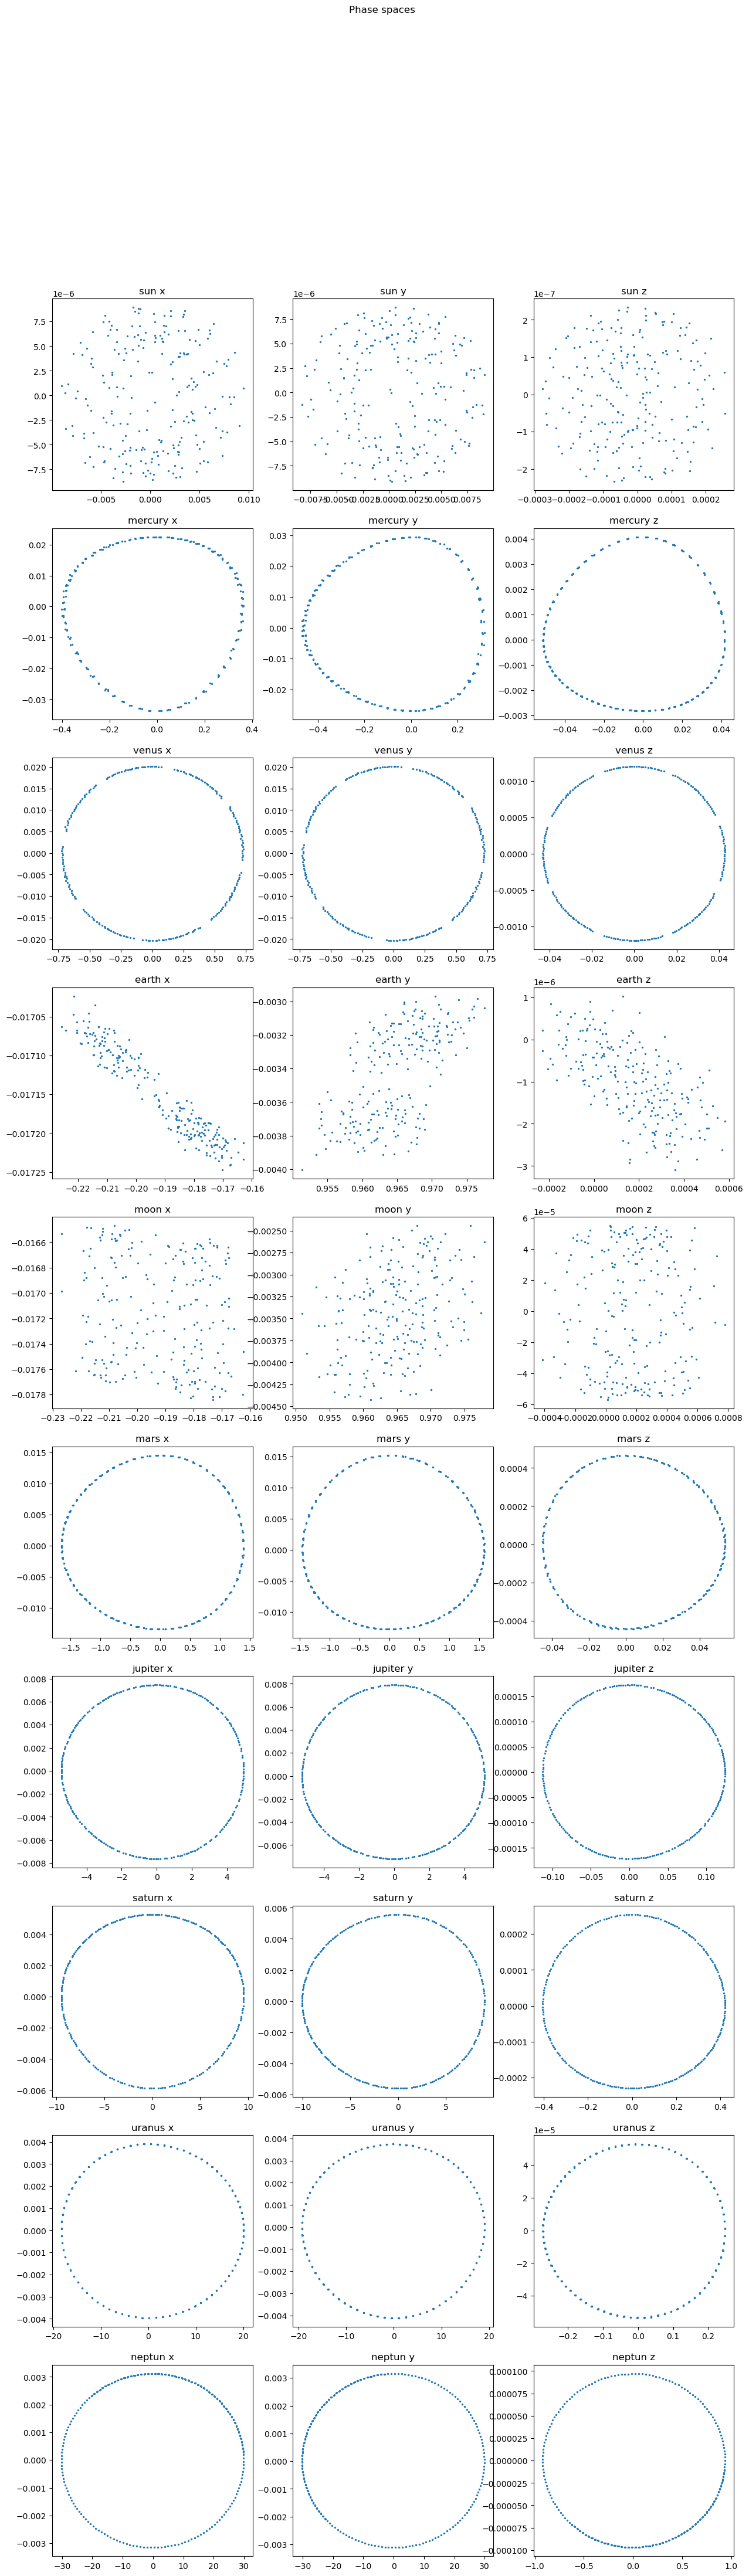

In [73]:
fig, axs = plt.subplots(len(target_names),3, figsize=(15,5*len(target_names)))
coords = ["x", "y", "z"]

for i in range(len(target_names)):
    for j in range(0, 3):
        axs[i, j].scatter(data[i][0].T[j], data[i][1].T[j], s=2)
        axs[i, j].set_title(target_names[i] + " " + coords[j])


fig.suptitle("Phase spaces")

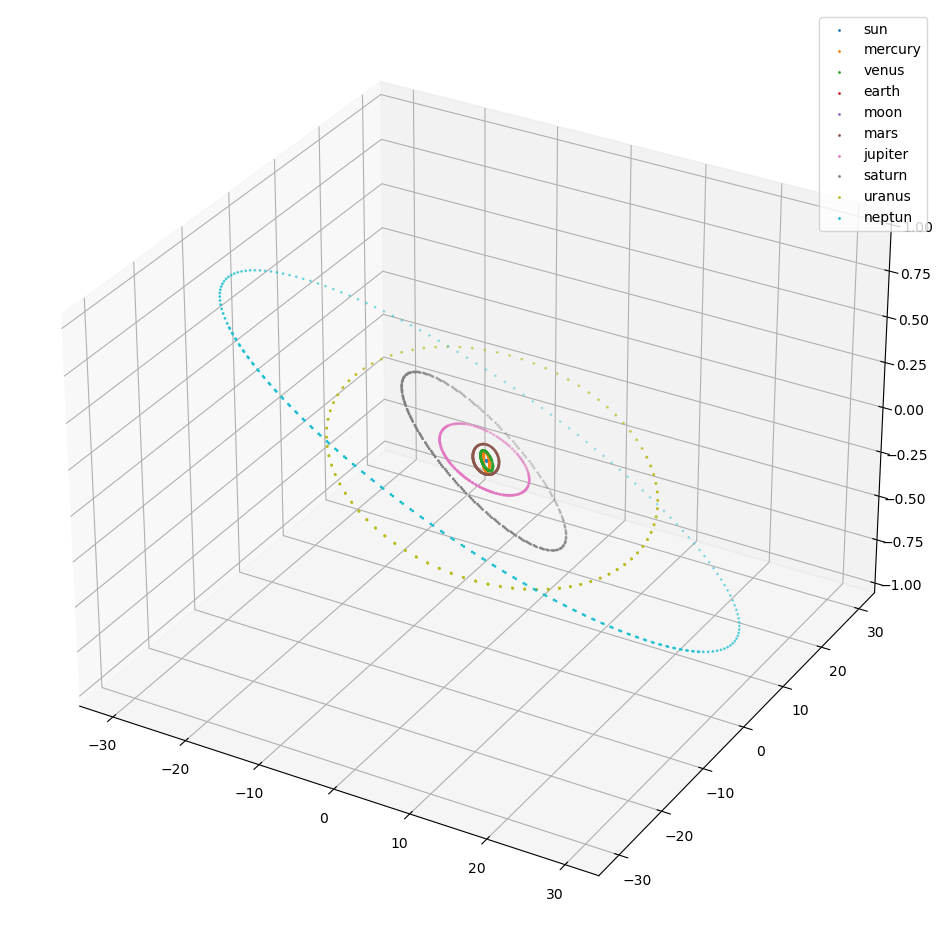

In [74]:
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(12)

ax = fig.add_subplot(projection='3d')

for i in range(len(target_names)):
    ax.scatter(data[i][0].T[0], data[i][0].T[1], data[i][0].T[2], s=1, label=target_names[i])

#ax.view_init(elev=0, roll=0, azim=300)
plt.legend()
plt.show()

# Learning the solar system

## Preparing the data

In [75]:
def prep_data(data):
    q = np.array([])
    dq = np.array([])
    p = np.array([])
    dp = np.array([])

    for j in range(len(data[0][0])-1):
        for i in range(len(data)):

            q = np.append(q, data[i][0][j])
            dq = np.append(dq, data[i][0][j+1]-data[i][0][j])

            p = np.append(p, data[i][1][j])
            dp = np.append(dp, data[i][1][j+1]-data[i][1][j])

    shape = [len(data[i][0])-1, 3*len(data)]

    return q.reshape(shape), dq.reshape(shape), p.reshape(shape), dp.reshape(shape)

In [76]:
q, dq, p, dp = prep_data(data)

q_p = np.concatenate((q, p), axis=1)
q_p = torch.tensor(q_p, requires_grad=True, dtype=torch.float32)

dq_dp = np.concatenate((dq, dp), axis=1)
dq_dp = torch.tensor(dq_dp, requires_grad=True, dtype=torch.float32)

## Normal Neural Network

In [77]:
class MLP(nn.Module):
    def __init__(self, bodys) -> None:
        super().__init__()

        self.fc1 = nn.Linear(bodys, 500)
        self.fc2 = nn.Linear(500, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, bodys)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

## Hamiltonian

In [78]:
def HNN(x, model):
    H = model(x)

    # this is where the HNN magic happens!!
    x_field = torch.autograd.grad(H.sum(), x, create_graph=True, retain_graph=True)[0] # gradients for field
    dH = torch.zeros_like(x_field)

    # Hamiltonian equations
    # dq = dH/dp
    dH.T[0] = x_field.T[3]
    dH.T[1] = x_field.T[4]
    dH.T[2] = x_field.T[5]

    # dp = -dH/dq
    dH.T[3] = -x_field.T[0]
    dH.T[4] = -x_field.T[1]
    dH.T[5] = -x_field.T[2]

    return dH

## Training loop

In [79]:
def train(model, x, dx, batch_size=32, epochs=100, baseline=True, lr=0.001):
    loss_hist = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.MSELoss()

    for step in range(epochs+1):
        model.train()
        for batch in range(0, len(x), batch_size):
            x_batch = x[batch:batch+batch_size]
            dx_batch = dx[batch:batch+batch_size]

            """x_batch = x_batch - x_batch.T.min(1)[0]
            x_batch = x_batch / x_batch.T.max(1)[0]

            dx_batch = dx_batch - dx_batch.T.min(1)[0]
            dx_batch = dx_batch / dx_batch.T.max(1)[0]"""

            optimizer.zero_grad()

            if baseline:
                pred = model(x_batch)
            else:   
                pred = HNN(x_batch, model)

            loss_val = loss(pred, dx_batch)
            loss_val.backward()
            optimizer.step()

        if step % (epochs/10) == 0:
            model.eval()
            if baseline:
                pred = model(x)
            else:   
                pred = HNN(x, model)

            loss_val = loss(pred, dx)
            loss_hist.append(loss_val.item())
            
            print(f"Epoch {step}/{epochs} --- Train-Loss: {loss_val.item()}")#{round(loss_val.item(), 3)}")

    plt.plot(loss_hist)

# Baseline NN

Epoch 0/100 --- Train-Loss: 0.3511872887611389
Epoch 10/100 --- Train-Loss: 0.23127031326293945
Epoch 20/100 --- Train-Loss: 0.02527223341166973
Epoch 30/100 --- Train-Loss: 0.06017081066966057
Epoch 40/100 --- Train-Loss: 0.017874492332339287
Epoch 50/100 --- Train-Loss: 0.0033428410533815622
Epoch 60/100 --- Train-Loss: 0.0014021436218172312
Epoch 70/100 --- Train-Loss: 0.0009149477700702846
Epoch 80/100 --- Train-Loss: 0.0022294374648481607
Epoch 90/100 --- Train-Loss: 0.0034838139545172453
Epoch 100/100 --- Train-Loss: 0.0007835706346668303


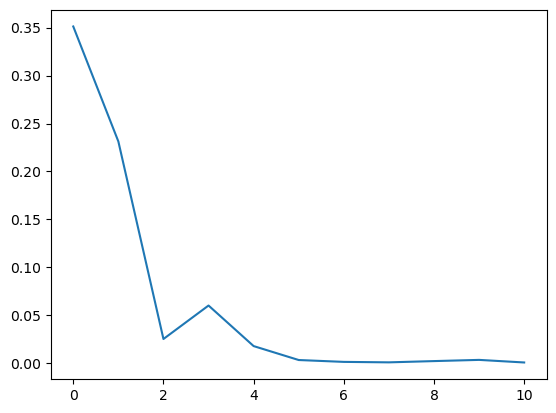

In [80]:
model_baseline = MLP(q_p.shape[1])

train(model=model_baseline, x=q_p, dx=dq_dp, batch_size=32, epochs=100, baseline=True, lr=1e-3)

# HNN

Epoch 0/100 --- Train-Loss: 0.43162840604782104
Epoch 10/100 --- Train-Loss: 0.43127763271331787
Epoch 20/100 --- Train-Loss: 0.43039825558662415
Epoch 30/100 --- Train-Loss: 0.42954573035240173
Epoch 40/100 --- Train-Loss: 0.42952871322631836
Epoch 50/100 --- Train-Loss: 0.42953887581825256
Epoch 60/100 --- Train-Loss: 0.4295150339603424
Epoch 70/100 --- Train-Loss: 0.42951977252960205
Epoch 80/100 --- Train-Loss: 0.429514080286026
Epoch 90/100 --- Train-Loss: 0.42952823638916016
Epoch 100/100 --- Train-Loss: 0.42951616644859314


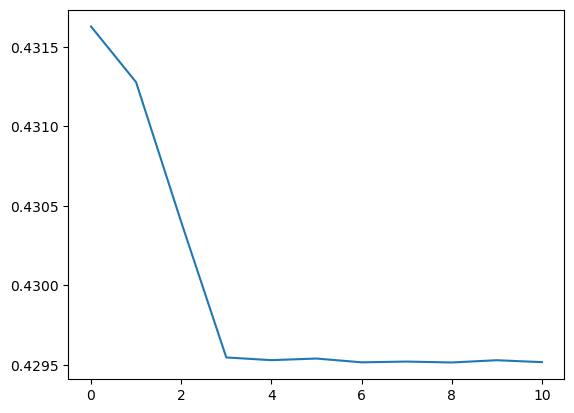

In [81]:
model_HNN = MLP(q_p.shape[1])

train(model=model_HNN, x=q_p, dx=dq_dp, batch_size=32, epochs=100, baseline=False, lr=1e-3)